In [20]:
from pyspark.sql import SparkSession

# New API
spark_session = SparkSession.builder\
        .master("spark://192.168.2.156:7077") \
        .appName("T")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",16)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .config("spark.executor.instances", 1)\
        .config("spark.ui.port", "8082")\
        .getOrCreate()




In [16]:
import time
import psutil
from pyspark.sql.functions import lower, regexp_replace, col, when, count, sum as spark_sum

# Define country, animal, and car brand lists
countries = ["China", "India", "United States", "Indonesia", "Pakistan", 
             "Brazil", "Nigeria", "Bangladesh", "Russia", "Mexico"]

animals = ["Dog", "Cow", "Monkey", "Lion", "Rhino", 
           "Tiger", "Hippo", "Cat", "Mouse", "Chicken"]

cars = ["Toyota", "Ford", "Honda", "BMW", "Mercedes", 
        "Audi", "Tesla", "Chevrolet", "Nissan", "Volkswagen"]

all_categories = countries + animals + cars

# Step 1) Preprocessing function
def preprocess_data(df):
    # Select only required columns
    df = df.select("subreddit", "body")

    # Handle NULL values (drop if both are NULL, otherwise keep but alter slightly)
    df = df.dropna(how="all", subset=["subreddit", "body"])
    df = df.withColumn("subreddit", when(col("subreddit").isNull(), "unknown").otherwise(col("subreddit")))
    df = df.withColumn("body", when(col("body").isNull(), "").otherwise(col("body")))

    # Convert text to lowercase & remove punctuation
    df = df.withColumn("body", lower(col("body")))
    df = df.withColumn("body", regexp_replace(col("body"), "[^a-zA-Z0-9\s]", ""))

    return df

# Step 2) Category count function
def mentions_counter(df, category_list, category_name):
    for item in category_list:
        df = df.withColumn(item, when(col("body").contains(item.lower()), 1).otherwise(0))
    
    category_mentions = df.groupBy("subreddit").sum(*category_list)
    
    # Summarize total mentions across all subreddits
    total_mentions = category_mentions.select(
        *[spark_sum(col(f"sum({item})")).alias(item) for item in category_list]
    )
    
    return category_mentions, total_mentions

# Step 3) Performance measurement function
def measure_performance(df, dataset_name, metrics_dict):
    """Measure execution time, CPU & memory usage, then store results in a dictionary."""
    
    # Capture system resource usage before execution
    cpu_before = psutil.cpu_percent(interval=None)
    memory_before = psutil.virtual_memory().used / (1024 ** 3)  # Convert bytes to GB

    # Measure execution time
    start_time = time.time()
    subreddit_country_mentions, total_country_mentions = mentions_counter(df, countries, "Countries")
    subreddit_animal_mentions, total_animal_mentions = mentions_counter(df, animals, "Animals")
    subreddit_car_mentions, total_car_mentions = mentions_counter(df, cars, "Cars")
    subreddit_all_mentions, total_all_mentions = mentions_counter(df, all_categories, "All Categories")
    end_time = time.time()

    # Capture system resource usage after execution
    cpu_after = psutil.cpu_percent(interval=None)
    memory_after = psutil.virtual_memory().used / (1024 ** 3)  # Convert bytes to GB

    # Peak memory usage
    memory_peak = psutil.Process().memory_info().rss / (1024 ** 3)  # Resident Set Size (RSS) in GB

    # Compute execution metrics
    execution_time = end_time - start_time
    cpu_usage = cpu_after - cpu_before
    memory_usage = memory_after - memory_before

    # Store results in dictionary
    metrics_dict[dataset_name] = {
        "Execution Time (s)": execution_time,
        "CPU Usage Change (%)": cpu_usage,
        "Memory Usage Change (GB)": memory_usage,
        "Peak Memory Usage (GB)": memory_peak
    }

    # Show sample output
    total_country_mentions.show()  # Show total country mentions across all subreddits
    total_animal_mentions.show()  # Show total animal mentions across all subreddits
    total_car_mentions.show()  # Show total car mentions across all subreddits
    total_all_mentions.show()  # Show total mentions across all categories

    print(f"Dataset: {dataset_name}")
    print(f"Execution Time: {execution_time:.4f} seconds")
    
    return metrics_dict  # Return updated metrics

In [17]:
# Step 4) Performance evaluation loop
metrics_results = {}  # Dictionary to store performance results

dataset_paths = [
    "hdfs://192.168.2.156:9000/data/reddit/reddit_50k.json",
    "hdfs://192.168.2.156:9000/data/reddit/reddit_100k.json",
    "hdfs://192.168.2.156:9000/data/reddit/reddit_200k.json",
    "hdfs://192.168.2.156:9000/data/reddit/reddit_500k.json",
    "hdfs://192.168.2.156:9000/data/reddit/corpus-webis-tldr-17.json", #FULL DATASET
]

for dataset_path in dataset_paths:
    dataset_name = dataset_path.split("/")[-1]  # Extract dataset name
    print(f"\nProcessing dataset: {dataset_name}")

    # Load dataset
    reddit_df = spark_session.read.json(dataset_path)

    # Preprocess data
    reddit_df = preprocess_data(reddit_df)

    # Measure performance & store results
    metrics_results = measure_performance(reddit_df, dataset_name, metrics_results)




Processing dataset: reddit_50k.json


+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|  332|  328|          268|       17|      62|    77|     14|        11|   333|   110|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+



+----+---+------+----+-----+-----+-----+----+-----+-------+
| Dog|Cow|Monkey|Lion|Rhino|Tiger|Hippo| Cat|Mouse|Chicken|
+----+---+------+----+-----+-----+-----+----+-----+-------+
|1229|744|   131|1558|   23|   75|   16|9034|  193|    310|
+----+---+------+----+-----+-----+-----+----+-----+-------+



25/03/09 16:04:48 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+----+-----+---+--------+----+-----+---------+------+----------+
|Toyota|Ford|Honda|BMW|Mercedes|Audi|Tesla|Chevrolet|Nissan|Volkswagen|
+------+----+-----+---+--------+----+-----+---------+------+----------+
|    32| 915|   53| 42|      25| 781|   23|        6|    12|        10|
+------+----+-----+---+--------+----+-----+---------+------+----------+



+-----+-----+-------------+---------+--------+------+-------+----------+------+------+----+---+------+----+-----+-----+-----+----+-----+-------+------+----+-----+---+--------+----+-----+---------+------+----------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico| Dog|Cow|Monkey|Lion|Rhino|Tiger|Hippo| Cat|Mouse|Chicken|Toyota|Ford|Honda|BMW|Mercedes|Audi|Tesla|Chevrolet|Nissan|Volkswagen|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+----+---+------+----+-----+-----+-----+----+-----+-------+------+----+-----+---+--------+----+-----+---------+------+----------+
|  332|  328|          268|       17|      62|    77|     14|        11|   333|   110|1229|744|   131|1558|   23|   75|   16|9034|  193|    310|    32| 915|   53| 42|      25| 781|   23|        6|    12|        10|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+----+---+------+----+-----+-----+-----+----+-----+----

+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|  689|  690|          528|       56|     114|   147|     34|        18|   702|   240|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+



+----+----+------+----+-----+-----+-----+-----+-----+-------+
| Dog| Cow|Monkey|Lion|Rhino|Tiger|Hippo|  Cat|Mouse|Chicken|
+----+----+------+----+-----+-----+-----+-----+-----+-------+
|2464|1417|   267|3133|   50|  164|   32|18078|  406|    565|
+----+----+------+----+-----+-----+-----+-----+-----+-------+



+------+----+-----+---+--------+----+-----+---------+------+----------+
|Toyota|Ford|Honda|BMW|Mercedes|Audi|Tesla|Chevrolet|Nissan|Volkswagen|
+------+----+-----+---+--------+----+-----+---------+------+----------+
|    66|1869|   96| 81|      49|1552|   54|        9|    31|        17|
+------+----+-----+---+--------+----+-----+---------+------+----------+



+-----+-----+-------------+---------+--------+------+-------+----------+------+------+----+----+------+----+-----+-----+-----+-----+-----+-------+------+----+-----+---+--------+----+-----+---------+------+----------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico| Dog| Cow|Monkey|Lion|Rhino|Tiger|Hippo|  Cat|Mouse|Chicken|Toyota|Ford|Honda|BMW|Mercedes|Audi|Tesla|Chevrolet|Nissan|Volkswagen|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+----+----+------+----+-----+-----+-----+-----+-----+-------+------+----+-----+---+--------+----+-----+---------+------+----------+
|  689|  690|          528|       56|     114|   147|     34|        18|   702|   240|2464|1417|   267|3133|   50|  164|   32|18078|  406|    565|    66|1869|   96| 81|      49|1552|   54|        9|    31|        17|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+----+----+------+----+-----+-----+-----+-----+

+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
| 1406| 1412|         1115|      119|     222|   281|     84|        32|  1413|   492|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+



+----+----+------+----+-----+-----+-----+-----+-----+-------+
| Dog| Cow|Monkey|Lion|Rhino|Tiger|Hippo|  Cat|Mouse|Chicken|
+----+----+------+----+-----+-----+-----+-----+-----+-------+
|4728|2850|   496|6245|   95|  337|   61|35987|  777|   1184|
+----+----+------+----+-----+-----+-----+-----+-----+-------+



+------+----+-----+---+--------+----+-----+---------+------+----------+
|Toyota|Ford|Honda|BMW|Mercedes|Audi|Tesla|Chevrolet|Nissan|Volkswagen|
+------+----+-----+---+--------+----+-----+---------+------+----------+
|   154|3719|  209|177|      98|3211|  130|       15|    67|        28|
+------+----+-----+---+--------+----+-----+---------+------+----------+



+-----+-----+-------------+---------+--------+------+-------+----------+------+------+----+----+------+----+-----+-----+-----+-----+-----+-------+------+----+-----+---+--------+----+-----+---------+------+----------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico| Dog| Cow|Monkey|Lion|Rhino|Tiger|Hippo|  Cat|Mouse|Chicken|Toyota|Ford|Honda|BMW|Mercedes|Audi|Tesla|Chevrolet|Nissan|Volkswagen|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+----+----+------+----+-----+-----+-----+-----+-----+-------+------+----+-----+---+--------+----+-----+---------+------+----------+
| 1406| 1412|         1115|      119|     222|   281|     84|        32|  1413|   492|4728|2850|   496|6245|   95|  337|   61|35987|  777|   1184|   154|3719|  209|177|      98|3211|  130|       15|    67|        28|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+----+----+------+----+-----+-----+-----+-----+

+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
| 3585| 3462|         2790|      306|     510|   753|    202|        84|  3397|  1237|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+



+-----+----+------+-----+-----+-----+-----+-----+-----+-------+
|  Dog| Cow|Monkey| Lion|Rhino|Tiger|Hippo|  Cat|Mouse|Chicken|
+-----+----+------+-----+-----+-----+-----+-----+-----+-------+
|11807|7131|  1304|15525|  233|  814|  164|89723| 2060|   2973|
+-----+----+------+-----+-----+-----+-----+-----+-----+-------+



+------+----+-----+---+--------+----+-----+---------+------+----------+
|Toyota|Ford|Honda|BMW|Mercedes|Audi|Tesla|Chevrolet|Nissan|Volkswagen|
+------+----+-----+---+--------+----+-----+---------+------+----------+
|   368|9321|  532|474|     259|8176|  301|       43|   176|        67|
+------+----+-----+---+--------+----+-----+---------+------+----------+



+-----+-----+-------------+---------+--------+------+-------+----------+------+------+-----+----+------+-----+-----+-----+-----+-----+-----+-------+------+----+-----+---+--------+----+-----+---------+------+----------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico|  Dog| Cow|Monkey| Lion|Rhino|Tiger|Hippo|  Cat|Mouse|Chicken|Toyota|Ford|Honda|BMW|Mercedes|Audi|Tesla|Chevrolet|Nissan|Volkswagen|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+-----+----+------+-----+-----+-----+-----+-----+-----+-------+------+----+-----+---+--------+----+-----+---------+------+----------+
| 3585| 3462|         2790|      306|     510|   753|    202|        84|  3397|  1237|11807|7131|  1304|15525|  233|  814|  164|89723| 2060|   2973|   368|9321|  532|474|     259|8176|  301|       43|   176|        67|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+-----+----+------+-----+-----+-----+--

+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|22761|24068|        17899|     1839|    3156|  6238|   1228|       605| 21496|  9070|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+



+------+-----+------+------+-----+-----+-----+------+-----+-------+
|   Dog|  Cow|Monkey|  Lion|Rhino|Tiger|Hippo|   Cat|Mouse|Chicken|
+------+-----+------+------+-----+-----+-----+------+-----+-------+
|105571|80210|  9986|106210| 1884| 5963| 1330|802081|19690|  25353|
+------+-----+------+------+-----+-----+-----+------+-----+-------+



+------+-----+-----+----+--------+-----+-----+---------+------+----------+
|Toyota| Ford|Honda| BMW|Mercedes| Audi|Tesla|Chevrolet|Nissan|Volkswagen|
+------+-----+-----+----+--------+-----+-----+---------+------+----------+
|  2793|90096| 4371|3112|    1765|61889| 2187|      269|  1397|       546|
+------+-----+-----+----+--------+-----+-----+---------+------+----------+



[Stage 119:====================================================>(146 + 1) / 147]

+-----+-----+-------------+---------+--------+------+-------+----------+------+------+------+-----+------+------+-----+-----+-----+------+-----+-------+------+-----+-----+----+--------+-----+-----+---------+------+----------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico|   Dog|  Cow|Monkey|  Lion|Rhino|Tiger|Hippo|   Cat|Mouse|Chicken|Toyota| Ford|Honda| BMW|Mercedes| Audi|Tesla|Chevrolet|Nissan|Volkswagen|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+------+-----+------+------+-----+-----+-----+------+-----+-------+------+-----+-----+----+--------+-----+-----+---------+------+----------+
|22761|24068|        17899|     1839|    3156|  6238|   1228|       605| 21496|  9070|105571|80210|  9986|106210| 1884| 5963| 1330|802081|19690|  25353|  2793|90096| 4371|3112|    1765|61889| 2187|      269|  1397|       546|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+------+---

/tmp/ipykernel_106149/1883146729.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(metrics_df.index, rotation=45)
/tmp/ipykernel_106149/1883146729.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(metrics_df.index, rotation=45)
/tmp/ipykernel_106149/1883146729.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(metrics_df.index, rotation=45)


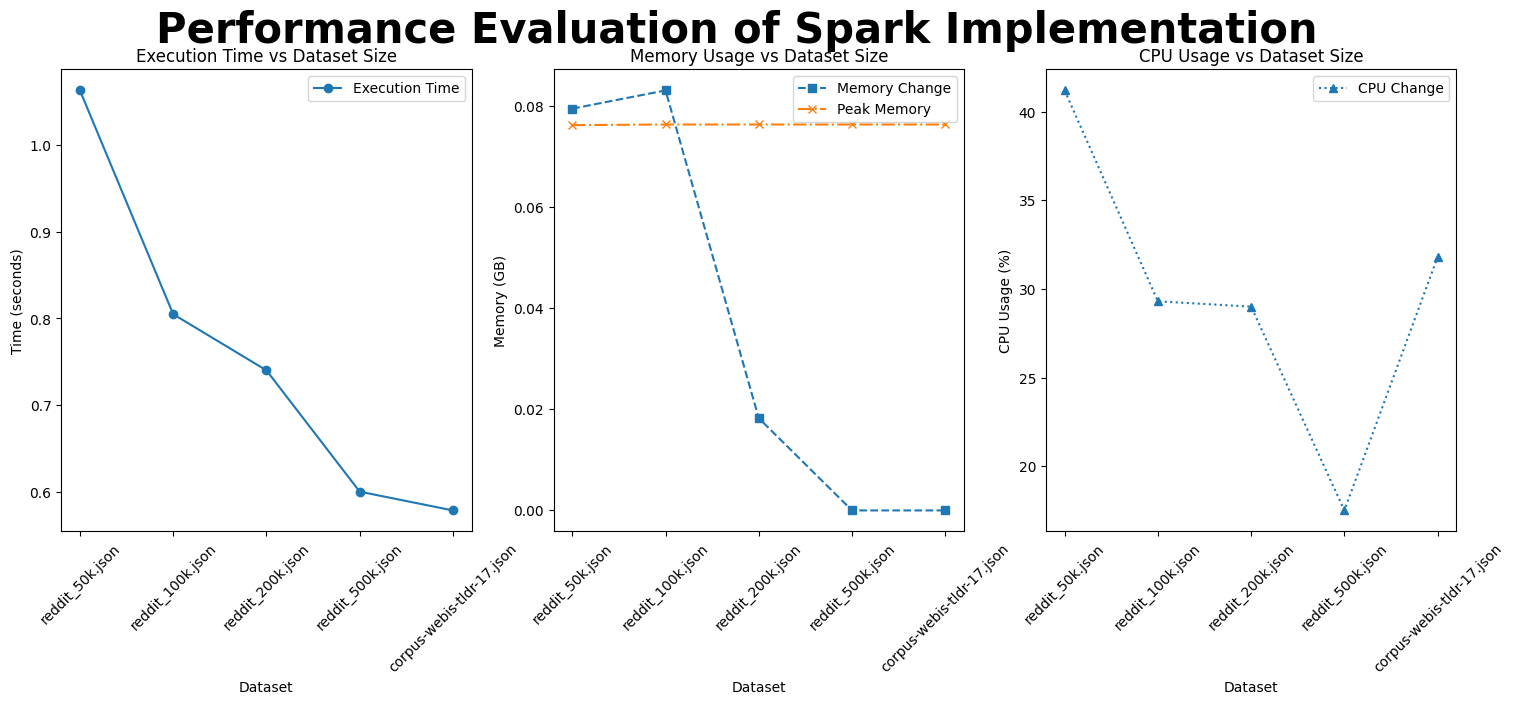

In [21]:
# Step 5) Plotting the result
import pandas as pd
import matplotlib.pyplot as plt

# Convert dictionary to DataFrame
metrics_df = pd.DataFrame.from_dict(metrics_results, orient="index")

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
fig.suptitle(r"Performance Evaluation of Spark Implementation", fontsize=30, fontweight='bold')
# Plot execution time vs. dataset size
axes[0].plot(metrics_df.index, metrics_df["Execution Time (s)"], marker="o", linestyle="-", label="Execution Time")
axes[0].set_xlabel("Dataset")
axes[0].set_ylabel("Time (seconds)")
axes[0].set_title("Execution Time vs Dataset Size")
axes[0].legend()
axes[0].set_xticklabels(metrics_df.index, rotation=45)

# Plot memory usage
axes[1].plot(metrics_df.index, metrics_df["Memory Usage Change (GB)"], marker="s", linestyle="--", label="Memory Change")
axes[1].plot(metrics_df.index, metrics_df["Peak Memory Usage (GB)"], marker="x", linestyle="-.", label="Peak Memory")
axes[1].set_xlabel("Dataset")
axes[1].set_ylabel("Memory (GB)")
axes[1].set_title("Memory Usage vs Dataset Size")
axes[1].legend()
axes[1].set_xticklabels(metrics_df.index, rotation=45)

# Plot CPU usage
axes[2].plot(metrics_df.index, metrics_df["CPU Usage Change (%)"], marker="^", linestyle=":", label="CPU Change")
axes[2].set_xlabel("Dataset")
axes[2].set_ylabel("CPU Usage (%)")
axes[2].set_title("CPU Usage vs Dataset Size")
axes[2].legend()
axes[2].set_xticklabels(metrics_df.index, rotation=45)
plt.savefig("Performance_evaluation2.png", dpi=300)
plt.show()

In [22]:
# Terminate session
spark_session.stop()